In [1]:
import sys
path = '/home/artem/PythonProjects/ML_Abalone_Homework/venv/lib/python3.12/site-packages'
if path not in sys.path:
    sys.path.append(path)

<span style="color: blue">**Sex**</span> - ***Пол*** - номинальный - M, F и I (младенцы)  
<span style="color: blue">**Length**</span> - ***Длина*** - непрерывная - мм - Самый длинный размер раковины  
<span style="color: blue">**Diameter**</span> - ***Диаметр*** - непрерывный - мм - перпендикулярен длине  
<span style="color: blue">**Height**</span> - ***Высота*** - непрерывный - мм - с мясом в раковине  
<span style="color: blue">**Whole weight**</span> - ***Общий вес*** - непрерывный - граммы - целое морское ушко  
<span style="color: blue">**Shucked weight**</span> - ***Вес очищенного от кожуры мяса*** - непрерывный - в граммах  
<span style="color: blue">**Viscera weight**</span> - ***Вес внутренностей*** - непрерывный - в граммах - вес потрохов (после обескровливания)  
<span style="color: blue">**Shell weight**</span> - ***Вес скорлупы*** - непрерывный - в граммах - после сушки  
<span style="color: red">**Rings**</span> - ***Количество колец*** - целое число - +1,5 указывает возраст в годах (целевой показатель)

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import polars as pl

In [3]:
df = pd.read_csv('abalone.csv', delimiter=',', encoding='utf-8') #считываем файл

# Изучение и анализ данных

In [4]:
df.shape #выводим габариты таблицы - 4177 строк, 9 столбцов

(4177, 9)

In [5]:
df.info() #выводим аналитическую справку о датафрейме
#P.S. столбец Sex содержит значения типа object, среди которых могут быть ошибки
#P.S. из справки определяем, что 2, 4 и 7 столбцы имеют null-значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


# Исправление ошибок

In [6]:
df.Sex.value_counts() #Выводим таблицу, группированную по категориям столбца Sex
#P.S. видим, что у 195 позиций пол морского ушка записан с прописной f

Sex
M    1447
I    1276
F    1259
f     195
Name: count, dtype: int64

In [7]:
df.replace(to_replace='f', value='F', inplace=True) #меняем значения
df.Sex.value_counts() #проверяем выполнение замены

Sex
F    1454
M    1447
I    1276
Name: count, dtype: int64

# Работа над пустыми ячейками

In [8]:
df.isnull().mean() #рассчитываем долю пустых ячеек
# видим, что пустых ячеек более 1%. Исходя из этого пустые ячейки заполним медианным значением

Sex               0.000000
Length            0.000000
Diameter          0.023701
Height            0.000000
Whole weight      0.023701
Shucked weight    0.000000
Viscera weight    0.000000
Shell weight      0.011970
Rings             0.000000
dtype: float64

In [9]:
#рассчитываем медианное значение по столбцу и заполняем пустые ячейки
diam_med = df['Diameter'].median()
whole_med = df['Whole weight'].median()
shell_med = df['Shell weight'].median()
df.fillna({'Diameter': diam_med, 'Whole weight': whole_med, 'Shell weight': shell_med}, inplace=True)

df.isnull().sum().sum() #проверяем количество пустых ячеек

0

# Работа над дубликатами

In [10]:
df.duplicated().sum() #подсчитываем количество повторяющихся строк
#P.S. видим, что дублирующихся данных о морском ушке нет

0

# Анализ столбцов. Удаление выбросов

array([[<AxesSubplot: title={'center': 'Length'}>,
        <AxesSubplot: title={'center': 'Diameter'}>,
        <AxesSubplot: title={'center': 'Height'}>],
       [<AxesSubplot: title={'center': 'Whole weight'}>,
        <AxesSubplot: title={'center': 'Shucked weight'}>,
        <AxesSubplot: title={'center': 'Viscera weight'}>],
       [<AxesSubplot: title={'center': 'Shell weight'}>,
        <AxesSubplot: title={'center': 'Rings'}>, <AxesSubplot: >]],
      dtype=object)

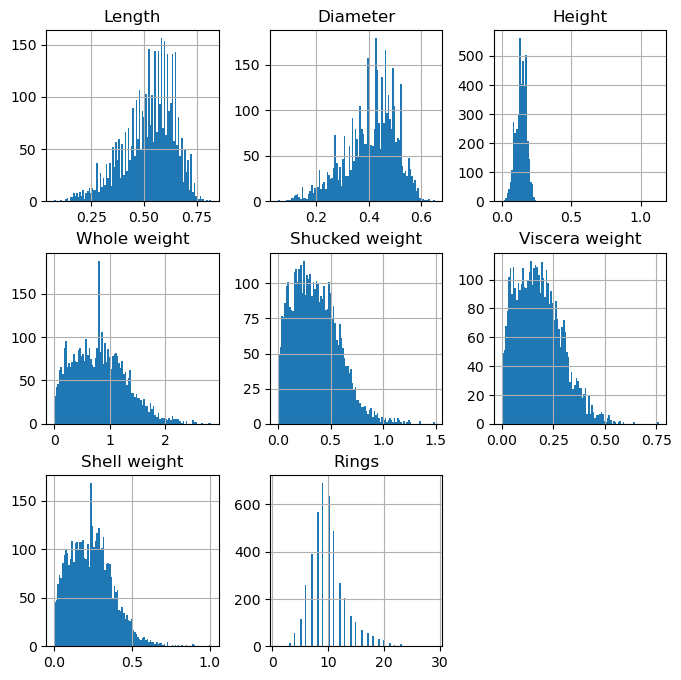

In [11]:
df.hist(bins=100, figsize=(8,8)) #строим гистограммы по каждому столбцу
#P.S. у столбца Height отчетливо видны аномальные выбросы при значениях выше 0,25
#P.S. у столбца Shucked weight отчетливо видны аномальные выбросы при значениях выше 1,3 
#P.S. у столбца Viscera weight отчетливо видны аномальные выбросы при значениях выше 0,6 

In [12]:
df[df['Height']>0.25] #смотрим, сколько позиций со значением Height>0.25
#P.S. Две позиции с Height более чем в 2 и в 4 раза больше, чем у большинства объектов. Удалим позиции с выбросами

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1417,M,0.705,0.565,0.515,2.210,1.1075,0.4865,0.5120,10
2051,F,0.455,0.355,1.130,0.594,0.3320,0.1160,0.1335,8


In [13]:
df = df.drop(df[df.Height>0.25].index, axis=0) #удаляем две позиции с аномальными выбросами по Height

In [14]:
df[df['Shucked weight']>1.3] #смотрим, сколько позиций со значением Shucked weight>1,3
#P.S. Три позиции с Shucked weight значительно превышают значения большинства объектов. Удалим позиции с выбросами

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1209,F,0.780,0.630,0.215,2.6570,1.4880,0.4985,0.5860,11
1528,M,0.725,0.575,0.240,2.2100,1.3510,0.4130,0.5015,13
1763,M,0.775,0.630,0.250,2.7795,1.3485,0.7600,0.5780,12


In [15]:
df = df.drop(df[df['Shucked weight']>1.3].index, axis=0) #удаляем две позиции с аномальными выбросами по Shucked weight

In [16]:
df[df['Viscera weight']>0.6] #смотрим, сколько позиций со значением Viscera weight>0.6
#P.S. Одна позиция с Viscera weight значительно превышает значения большинства объектов. Удалим позицию с выбросом

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1762,M,0.77,0.62,0.195,2.5155,1.1155,0.6415,0.642,12


In [17]:
df = df.drop(df[df['Viscera weight']>0.6].index, axis=0) #удаляем позицию с аномальным выбросом по Viscera weight

array([[<AxesSubplot: title={'center': 'Length'}>,
        <AxesSubplot: title={'center': 'Diameter'}>,
        <AxesSubplot: title={'center': 'Height'}>],
       [<AxesSubplot: title={'center': 'Whole weight'}>,
        <AxesSubplot: title={'center': 'Shucked weight'}>,
        <AxesSubplot: title={'center': 'Viscera weight'}>],
       [<AxesSubplot: title={'center': 'Shell weight'}>,
        <AxesSubplot: title={'center': 'Rings'}>, <AxesSubplot: >]],
      dtype=object)

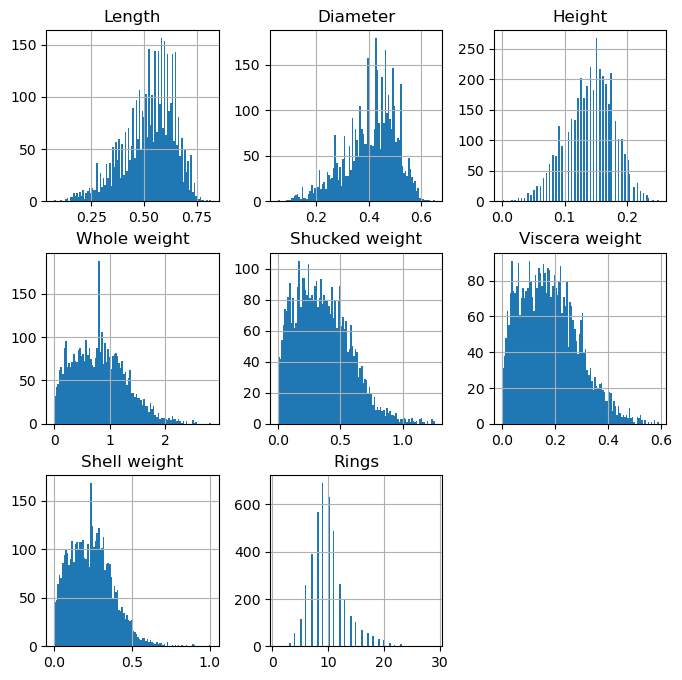

In [18]:
df.hist(bins=100, figsize=(8,8))

# Изучение взаимосвязи каждого столбца с целевой переменной Rings


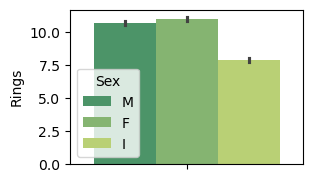

In [19]:
plt.figure(figsize=(3,2))
sns.barplot(hue='Sex', y='Rings', data=df, palette='summer') #взаимосвязь категориального и числового столбцов
plt.show()
#P.S. взаимосвязи между полом и количеством колец не видно. Среднее значение количества колец у мужских и женских особей приблизительно одинаково. У детенышей незначительно меньше
#Из исследуемых морских ушек женские особи были с б`ольшим количеством колец, чем мужские и детеныши

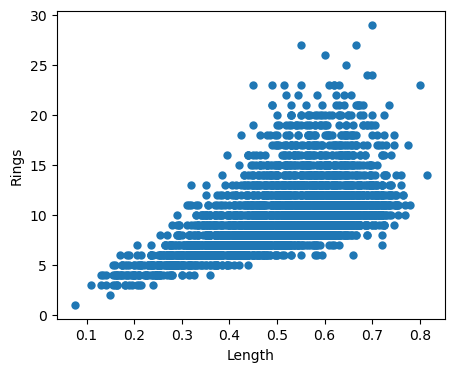

In [20]:
plt.figure(figsize=(5,4))
plt.scatter(df['Length'], df['Rings'], linewidth=0)
plt.xlabel('Length')
plt.ylabel('Rings')
plt.show()

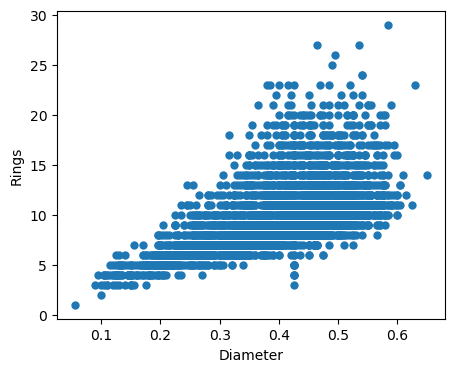

In [21]:
plt.figure(figsize=(5,4))
plt.scatter(df['Diameter'], df['Rings'], linewidth=0)
plt.xlabel('Diameter')
plt.ylabel('Rings')
plt.show()

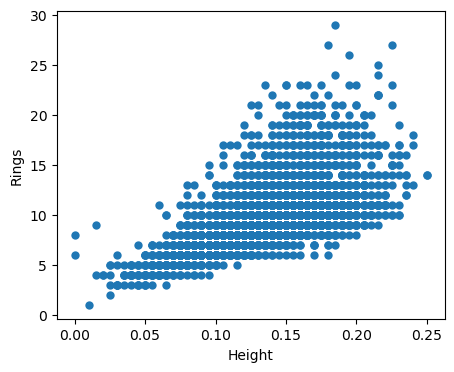

In [22]:
plt.figure(figsize=(5,4))
plt.scatter(df['Height'], df['Rings'], linewidth=0)
plt.xlabel('Height')
plt.ylabel('Rings')
plt.show()

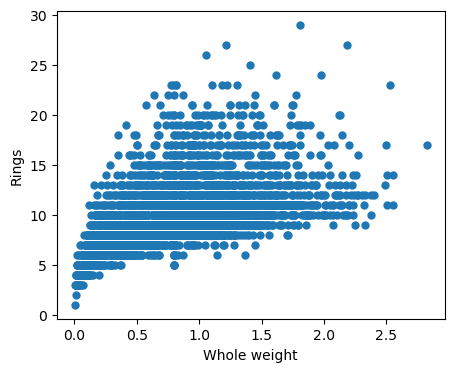

In [23]:
plt.figure(figsize=(5,4))
plt.scatter(df['Whole weight'], df['Rings'], linewidth=0)
plt.xlabel('Whole weight')
plt.ylabel('Rings')
plt.show()

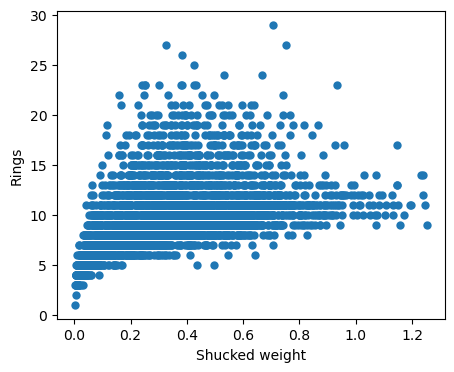

In [24]:
plt.figure(figsize=(5,4))
plt.scatter(df['Shucked weight'], df['Rings'], linewidth=0)
plt.xlabel('Shucked weight')
plt.ylabel('Rings')
plt.show()

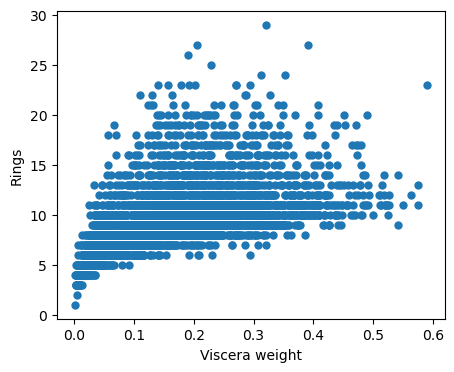

In [25]:
plt.figure(figsize=(5,4))
plt.scatter(df['Viscera weight'], df['Rings'], linewidth=0)
plt.xlabel('Viscera weight')
plt.ylabel('Rings')
plt.show()

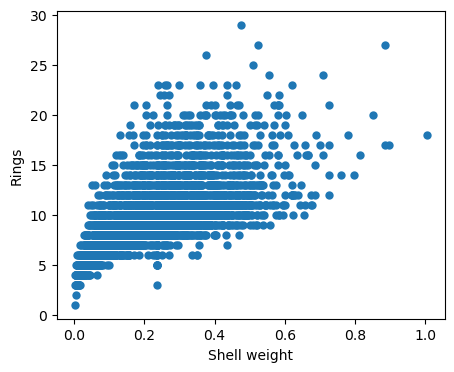

In [26]:
plt.figure(figsize=(5,4))
plt.scatter(df['Shell weight'], df['Rings'], linewidth=0)
plt.xlabel('Shell weight')
plt.ylabel('Rings')
plt.show()

In [27]:
#P.S. согласно диаграммам рассеяния можно сделать выводы, что все числовые признаки имеют связь с целевой переменной.
#Но это не может свидетельствовать о том, что целевая переменная является причиной признака; возможно, обе исследуемые переменные являются следствием изменения третьей переменной или комплекса других факторов
#На всех диаграммах наблюдается положительная корреляция
#Аномальных выбросов нет или они немногочисленны и незначительны

# Расчет корреляции

In [28]:
#Для расчета зависимости категориального признака и целевой переменной считаем ANOVA
data_result = []
for i in df.columns:
    for j in df.columns:
        if df[i].dtype == 'object' and df[j].dtype != 'object':
            category_group_list = df.groupby(i)[j].apply(list)
            anova = f_oneway(*category_group_list)
            
            if anova[1]>= 0.05:
                data_result.append({'Категориальный признак': i, 'Числовой признак': j, 'Коррелируются': "Нет"})
            else:
                data_result.append({'Категориальный признак': i, 'Числовой признак': j, 'Коррелируются': "Да"})
anova_res = pd.DataFrame.from_dict(data_result)
anova_res
#P.S. Результаты расчета показывают, что все числовые признаки коррелируют с полом морского ушка

,Категориальный признак,Числовой признак,Коррелируются
0,Sex,Length,Да
1,Sex,Diameter,Да
2,Sex,Height,Да
3,Sex,Whole weight,Да
4,Sex,Shucked weight,Да
5,Sex,Viscera weight,Да
6,Sex,Shell weight,Да
7,Sex,Rings,Да


Text(0.5, 1.0, 'PEARSON')

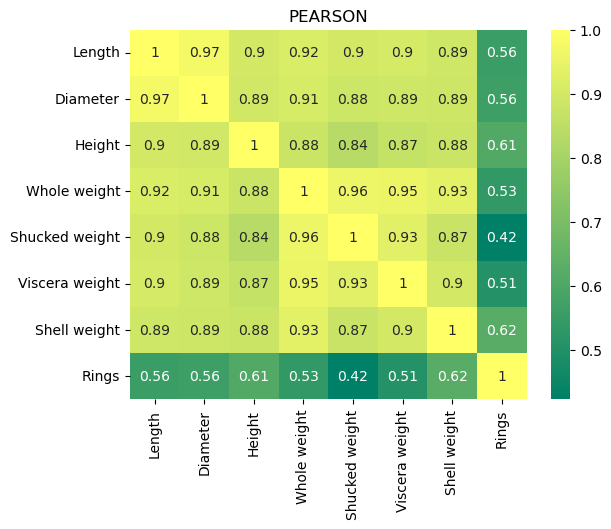

In [29]:
correlation = df.corr(numeric_only=True) #считаем корреляцию Пирсона
sns.heatmap(correlation, annot=True, cmap='summer') #визуализируем
plt.title('PEARSON')
#P.S. Согласно матрице корреляции Пирсона влияние числовых признаков на целевую переменную средняя - от 0,51(Viscera weight) до 0,62(Shell weight)
#Взаимосвязь числовых признаков между собой высокая - от 0,84 до 0,97.
#Подтверждается вывод, сделанный ранее, что корреляция положительная.
#Максимальная корреляция у связи Length-Diameter (0,97) минимальная у связи у связи Height-Shucked weight (0,84)

Text(0.5, 1.0, 'SPEARMAN')

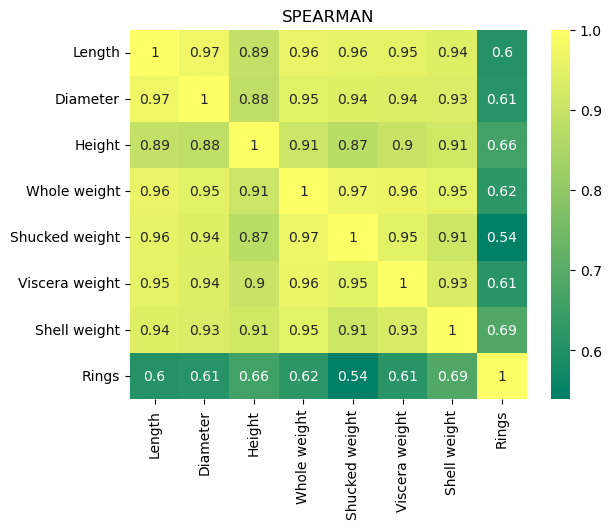

In [30]:
correlation = df.corr(numeric_only=True, method='spearman') #считаем корреляцию Спирмана
sns.heatmap(correlation, annot=True, cmap='summer') #визуализируем
plt.title('SPEARMAN')
#P.S. Согласно матрице корреляции Спирмана влияние числовых признаков на целевую переменную выше корреляции Пирсона - от 0,54(Shucked weight) до 0,69(Shell weight)
#Взаимосвязь числовых признаков между собой высокая - от 0,87 до 0,97.
#Максимальная корреляция у связи Length-Diameter (0,97) минимальная у связи у связи Height-Shucked weight (0,87)

In [31]:
#Тест χ2 применяется, когда есть предположение о связи двух категориальных переменных. 
#Неприменим к данному домашнему заданию, т.к. в датафрейме только один категориальный признак

# Анализ целевой переменной

<AxesSubplot: xlabel='Rings', ylabel='Count'>

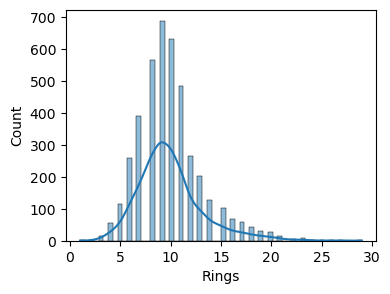

In [32]:
#Строим гистограмму целевой переменной
plt.figure(figsize=(4,3))
sns.histplot(data=df.Rings, kde=True, bins=60)
#P.S. График плотности распределения похож на нормальное распределение, но с небольшим смещением влево
# Значимое большинство объектов имеет количество колец от 6 до 13. Есть незначительное количество объектов с Rings>22 и Rings<3.
# Исходя из этого обученная модель будет хорошо предсказывать количество колец в диапазоне от 6 до 13
#и может некорректно работать предсказывая для объектов с 6>Rings>13

# <span style="color: red">Сравнение быстродействия Pandas и Polars</span>

In [33]:
#Увеличиваем размер датасета
ds = df.copy()

while len(ds)<10**6:
    ds = pd.concat([ds,df])

ds.to_csv('big_abalone', index=False)


In [34]:
%%time
df_pd = pd.read_csv('big_abalone', delimiter=',', encoding='utf-8')

CPU times: user 80.2 ms, sys: 237 ms, total: 317 ms
Wall time: 486 ms


In [35]:
%%time
df_pl = pl.read_csv('big_abalone')

CPU times: user 0 ns, sys: 216 ms, total: 216 ms
Wall time: 310 ms


In [36]:
#P.S. Считывание файла при использовании пакета Polars происходит почти в 2 раза быстрее, чем у Pandas

In [37]:
%%time
print(len(df_pd[df_pd.Rings>10]))

346320
CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 36.7 ms


In [38]:
%%time
print(len(df_pl.filter(pl.col('Rings')>10)))

346320
CPU times: user 0 ns, sys: 27.7 ms, total: 27.7 ms
Wall time: 97.8 ms


In [39]:
#P.S. Фильтрация пакетом Pandas происходит в 4 раза быстрее, чем Polars

In [40]:
%%time
df_pd.groupby('Sex')

CPU times: user 0 ns, sys: 145 µs, total: 145 µs
Wall time: 147 µs


In [41]:
%%time
df_pl.group_by('Sex')

CPU times: user 0 ns, sys: 11 µs, total: 11 µs
Wall time: 13.1 µs


In [42]:
#P.S. Агрегация пакетом Polars происходит в 7 раза быстрее, чем Pandas